# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Introduction

The Starbucks Udacity Data Scientist Nanodegree Capstone challenge data set is a simulation of customer behavior on the Starbucks rewards mobile application. Periodically, Starbucks sends offers to users that may be an advertisement, discount, or buy one get one free (BOGO). An important characteristic regarding this dataset is that not all users receive the same offer.

This data set contains three files. The first file describes the characteristics of each offer, including its duration and the amount a customer needs to spend to complete it (difficulty). The second file contains customer demographic data including their age, gender, income, and when they created an account on the Starbucks rewards mobile application. The third file describes customer purchases and when they received, viewed, and completed an offer. An offer is only successful when a customer both views an offer and meets or exceeds its difficulty within the offer's duration.

## Business Understanding
The problem is to build a model that predicts whether a customer will respond to an offer.
This problem is solved in four steps:
1. Combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful.
2. I will assess the accuracy and F1-score of a naive model that assumes all offers were successful. This provides me a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".
3. I will compare the performance of logistic regression, random forest, and gradient boosting models.
4. Refine the parameters of the model that has the highest accuracy and F1-score.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score,fbeta_score,make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Read Dataset

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Pre-processing

### Cleaning portfolio

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio = pd.get_dummies(portfolio,columns=['offer_type'],prefix='',prefix_sep='')
mlb = MultiLabelBinarizer()
mlb.fit(portfolio['channels'])
df =pd.DataFrame(mlb.transform(portfolio['channels']),columns=mlb.classes_)
portfolio = pd.concat([portfolio,df], axis=1)
portfolio = portfolio.drop(columns=['channels'])
first_col = portfolio.pop('id')
portfolio.insert(0, 'id', first_col)
portfolio.head()

,id,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1


In [5]:
portfolio.isna().sum()

id               0
difficulty       0
duration         0
reward           0
bogo             0
discount         0
informational    0
email            0
mobile           0
social           0
web              0
dtype: int64

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### Determine if any customer profile attributes contain missing values

In [7]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

#### Compute customer gender attribute distribution

In [8]:
gender_total = profile['gender'].value_counts()* (100/profile['gender'].value_counts().sum())
gender_total

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

#### Evaluate what year a customer became a rewards member

In [9]:
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [10]:
became_member = profile['became_member_on'].apply(convert_to_datetime)

start_yr = became_member.apply(lambda elem: elem.year).value_counts()
start_yr *= 100 / start_yr.sum()
start_yr

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

#### Evaluate which month a customer became a rewards member

In [11]:
start_mnt = became_member.apply(lambda elem: elem.month).value_counts()
start_mnt *= 100 / start_mnt.sum()
start_mnt

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

### Cleaning customer profile data

In [12]:
profile = profile[profile['income'].notnull()]
profile = profile[profile['gender'] != 'O']
profile = profile.reset_index(drop=True)
profile['became_member_on'] =profile['became_member_on'].apply(convert_to_datetime)
profile['membershipstartyear'] =profile['became_member_on'].apply(lambda elem: elem.year)
memshipstyr_df = pd.get_dummies(profile['membershipstartyear'])
min_agelimit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_agelimit = np.int(np.ceil(np.max(profile['age'])/10)*10)
profile['agerange'] = pd.cut(profile['age'],(range(min_agelimit,max_agelimit + 10, 10)),right=False)
profile['agerange'] = profile['agerange'].astype('str')
age_range_df = pd.get_dummies(profile['agerange'])
binarizerobj = LabelBinarizer()
profile['gender'] = binarizerobj.fit_transform(profile['gender'])
gender_integer_map = {}
for elem in binarizerobj.classes_:
    gender_integer_map[elem] = binarizerobj.transform([elem])[0,0]
profile = pd.concat([profile,age_range_df,memshipstyr_df], axis=1)
profile = profile.drop(columns=['age','agerange','became_member_on','membershipstartyear'])
first_col = profile.pop('id')
profile.insert(0, 'id', first_col)
profile.head()

,id,gender,income,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)",2013,2014,2015,2016,2017,2018
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [13]:
gender_integer_map

{'F': 0, 'M': 1}

In [14]:
profile.isna().sum()

id            0
gender        0
income        0
[10, 20)      0
[100, 110)    0
[20, 30)      0
[30, 40)      0
[40, 50)      0
[50, 60)      0
[60, 70)      0
[70, 80)      0
[80, 90)      0
[90, 100)     0
2013          0
2014          0
2015          0
2016          0
2017          0
2018          0
dtype: int64

### Income v/s Gender

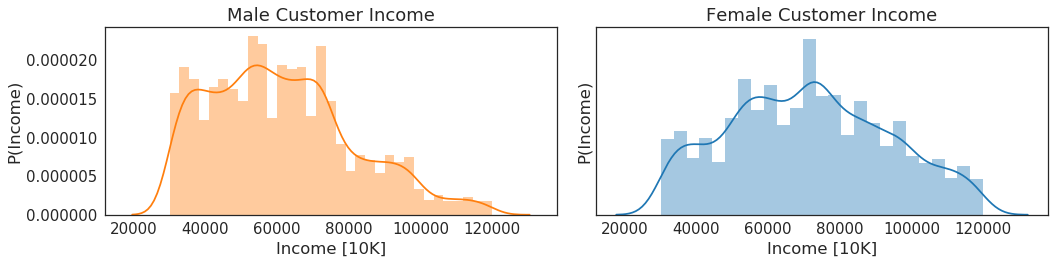

In [15]:
male_cust = profile[profile['gender'] == 1]
female_cust = profile[profile['gender'] == 0]
crr_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15, 4),nrows=1,ncols=2,sharex=True,sharey=True)
plt.sca(ax[0])
sns.distplot(male_cust['income'],color=crr_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')
plt.sca(ax[1])
sns.distplot(female_cust['income'],color=crr_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

#### Evaluate Membership Start Year Statistics

There are more male customers than female customers.And recently many customers has been joined.

In [16]:
def fetch_year(row):
    for column in [2013,2014,2015,2016,2017,2018]:
        if row[column] == 1:
            return column

In [17]:
mship_date = profile[['gender']].copy()
mship_date['startyear'] = profile.apply(fetch_year,axis=1)
mship_date.gender.replace({1:"Male",0:"Female"},inplace=True)
mship_date = mship_date.groupby(['startyear', 'gender']).size()
mship_date = mship_date.reset_index()
mship_date.columns = ['startyear', 'gender', 'count']
mship_date

,startyear,gender,count
0,2013,Female,74
1,2013,Male,197
2,2014,Female,138
3,2014,Male,520
4,2015,Female,663
5,2015,Male,905
6,2016,Female,1509
7,2016,Male,1483
8,2017,Female,2443
9,2017,Male,3067


Text(0,0.5,'Count')

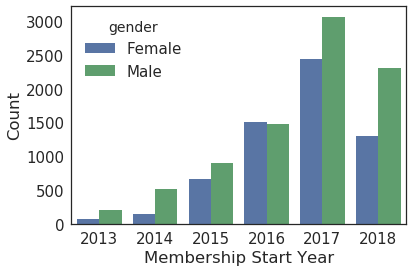

In [18]:
sns.barplot(x='startyear', y='count', hue='gender', data=mship_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

#### Compute customer gender distribution

In [19]:
mship_date.groupby('gender')['count'].sum()

gender
Female    6129
Male      8484
Name: count, dtype: int64

### Evaluate Age Range Statistics

In [20]:
def fetch_agerange(row):
    for column in ['[10, 20)','[100, 110)','[20, 30)','[30, 40)','[40, 50)','[50, 60)','[60, 70)','[70, 80)','[80, 90)','[90, 100)']:
        if row[column] == 1:
            return column

In [21]:
age_rng = profile[['gender']].copy()
age_rng['agerange'] = profile.apply(fetch_agerange,axis=1)
age_rng.gender.replace({1:"Male",0:"Female"},inplace=True)
age_rng = age_rng.groupby(['agerange', 'gender']).size()
age_rng = age_rng.reset_index()
age_rng.columns = ['agerange', 'gender', 'count']
age_rng

,agerange,gender,count
0,"[10, 20)",Female,45
1,"[10, 20)",Male,160
2,"[100, 110)",Female,14
3,"[100, 110)",Male,2
4,"[20, 30)",Female,393
5,"[20, 30)",Male,960
6,"[30, 40)",Female,495
7,"[30, 40)",Male,1008
8,"[40, 50)",Female,835
9,"[40, 50)",Male,1434


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

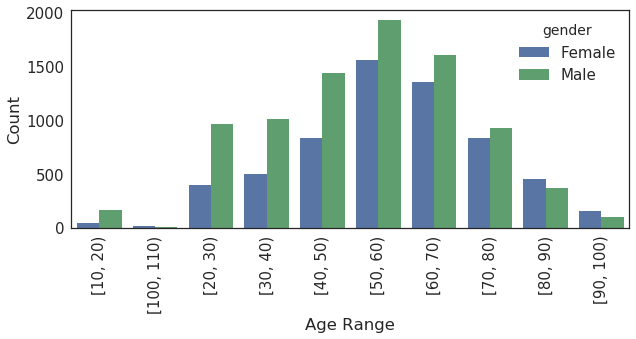

In [22]:
plt.figure(figsize=(10, 4))
sns.barplot(x='agerange', y='count', hue='gender', data=age_rng)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

These results suggest that the average customer age is between 50 and 60 years old.

### Clean Transcript data

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


#### Compute the event type distribution

In [24]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


#### Compute the percentage of customer transaction and offer events

In [25]:
total_tran = event_counts['count'].sum()

percent_tran = 100 * event_counts.iloc[0]['count'] / total_tran
percent_offer = 100 * event_counts.iloc[1:]['count'].sum() / total_tran

print("Customer transaction events percentage: %.1f %%" % (percent_tran))
print("Customer offer events percentage: %.1f %%" % (percent_offer))

Customer transaction events percentage: 45.3 %
Customer offer events percentage: 54.7 %


In [26]:
transcript = transcript[transcript['person'].isin(profile['id'])]
transcript['time'] /= 24.0
pattern_obj = re.compile('^offer (?:received|viewed|completed)')
h_is_offer = lambda elem: pattern_obj.match(elem) != None
is_offer = transcript['event'].apply(h_is_offer)
offer_data = transcript[is_offer].copy()
offer_data = offer_data.reset_index(drop=True)
offer_data['offerid'] =offer_data['value'].apply(lambda elem: list(elem.values())[0])
pattern_obj = re.compile('^offer ([a-z]+$)')
h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]
offer_data['event'] = offer_data['event'].apply(h_transform)
event_df = pd.get_dummies(offer_data['event'])
offer_data = pd.concat([offer_data, event_df], axis=1)
offer_data.drop(columns=['event', 'value'],inplace= True)
offer_data.head()

,person,time,offerid,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [27]:
transaction = transcript[is_offer == False]
transaction = transaction.reset_index(drop=True)
transaction['amount'] =transaction['value'].apply(lambda elem: list(elem.values())[0])
transaction = transaction.drop(columns=['event', 'value'])
transaction.head()

,person,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


### Merging our data

In [28]:
def create_combined_records(customer_id,portfolio,profile,offer_data,transaction):
    """ 
    Describes the effectiveness of offers to a specific customer
    INPUT:
        customer_id: String that refers to a specific customer
        profile: DataFrame that contains demographic data for each 
                 customer
                 
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    cur_customer = profile[profile['id'] == customer_id]
    select_offer_data = offer_data['person'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='person')
    customer_offer_data = customer_offer_data.reset_index(drop=True)
    select_transaction = transaction['person'] == customer_id
    customer_transaction_data = transaction[select_transaction]
    customer_transaction_data = customer_transaction_data.drop(columns='person')
    customer_transaction_data = customer_transaction_data.reset_index(drop=True)
    event_type = ['completed','received','viewed']
    offer_received = customer_offer_data[customer_offer_data['received'] == 1]
    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)
    offer_viewed =customer_offer_data[customer_offer_data['viewed'] == 1]
    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)
    offer_completed = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)
    rows = []
    for idx in range(offer_received.shape[0]):
        cur_offer_id = offer_received.iloc[idx]['offerid']
        cur_offer = portfolio.loc[portfolio['id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]
        cur_offer_startime = offer_received.iloc[idx]['time']
        cur_offer_endtime = offer_received.iloc[idx]['time'] + durationdays
        select_transaction = np.logical_and(customer_transaction_data['time'] >= cur_offer_startime,customer_transaction_data['time'] <= cur_offer_endtime)
        select_offer_completed = np.logical_and(offer_completed['time'] >= cur_offer_startime,offer_completed['time'] <= cur_offer_endtime)
        select_offer_viewed = np.logical_and(offer_viewed['time'] >= cur_offer_startime,offer_viewed['time'] <= cur_offer_endtime)
        cur_offer_successful = select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0
        cur_offer_transactions = customer_transaction_data[select_transaction]
        cur_row = {'id': cur_offer_id,'person': customer_id,'time': cur_offer_startime,'offersuccessful': int(cur_offer_successful),'totalamount': cur_offer_transactions['amount'].sum()}
        cur_row.update(cur_offer.iloc[0,1:].to_dict())
        cur_row.update(cur_customer.iloc[0,1:].to_dict())
        rows.append(cur_row)
    return rows

In [29]:
clean_data_path = "./data/final_clean_data.csv"
if os.path.exists(clean_data_path):
    clean_data = pd.read_csv(clean_data_path)
else:
    clean_data = []
    customerid_list = offer_data['person'].unique()
    for idx in range(len(customerid_list)):
        clean_data.extend(create_combined_records(customerid_list[idx],portfolio,profile,offer_data,transaction))
    clean_data = pd.DataFrame(clean_data)
    clean_data = clean_data.sort_values('time')
    clean_data.reset_index(drop=True)
    clean_data.to_csv("./data/final_clean_data.csv")
clean_data = clean_data.drop(columns=['Unnamed: 0','time','person','email','informational'])
clean_data = clean_data[['id','totalamount','difficulty','duration','reward','bogo','discount','mobile','social','income','gender','web','2013','2014','2015','2016','2017','2018',
            '[10, 20)','[20, 30)','[30, 40)','[40, 50)','[50, 60)','[60, 70)',
            '[70, 80)','[80, 90)','[90, 100)','[100, 110)','offersuccessful']]
clean_data.head()

,id,totalamount,difficulty,duration,reward,bogo,discount,mobile,social,income,...,"[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,5,7,5,1,0,1,0,100000.0,...,0,0,0,0,0,1,0,0,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,10,5,10,1,0,1,1,39000.0,...,0,0,0,1,0,0,0,0,0,1
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,3,0,0,0,1,1,52000.0,...,0,0,1,0,0,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,5,7,5,1,0,1,0,118000.0,...,0,0,0,0,0,1,0,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,10,10,2,0,1,1,1,44000.0,...,0,1,0,0,0,0,0,0,0,0


### Train Test Split

In [30]:
X = clean_data.drop(['offersuccessful'],axis=1)
y = clean_data.offersuccessful

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=3154220327)

In [32]:
column_names = X.columns[2:]
offerid_train = X_train.iloc[:, 0]
totalamount_train = X_train.iloc[:, 1]
X_train = X_train.iloc[:, 2:].astype('float64')
offerid_test = X_test.iloc[:, 0]
totalamount_test = X_test.iloc[:, 1]
X_test = X_test.iloc[:, 2:].astype('float64')
y_train = y_train.ravel()
y_test = y_test.ravel()

In [33]:
train_var = pd.DataFrame(X_train, columns=column_names)
train_label = pd.DataFrame(y_train, columns=['offersuccessful'])
train_offerid = pd.DataFrame(offerid_train, columns=['id'])
train_data = pd.concat([train_offerid,train_var,train_label], axis=1)
train_data.drop(columns=['difficulty','duration','reward','bogo','discount','mobile','social','web'],inplace=True)
train_data.head()

,id,income,gender,2013,2014,2015,2016,2017,2018,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,100000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,39000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5a8bc65990b245e5a138643cd4eb9837,52000.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,118000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,fafdcd668e3743c1bb461111dcafc2a4,44000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploring Offer

In [34]:
successful_count =train_data[['id','offersuccessful']].groupby('id').sum().reset_index()
offer_count = train_data['id'].value_counts()
offer_count = pd.DataFrame(list(zip(offer_count.index.values,offer_count.values)),columns=['id', 'count'])
successful_count = successful_count.sort_values('id')
offer_count = offer_count.sort_values('id')
percent_success = pd.merge(offer_count, successful_count, on="id")
percent_success['percentsuccess'] = 100 * percent_success['offersuccessful'] / percent_success['count']
percent_success = pd.merge(percent_success,portfolio,on="id")
percent_success = percent_success.drop(columns=['offersuccessful'])
percent_success = percent_success.sort_values('percentsuccess',ascending=False)
percent_success.head()

,id,count,percentsuccess,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5330,38.574109,20,10,5,0,1,0,1,0,0,1
5,5a8bc65990b245e5a138643cd4eb9837,5228,38.561591,0,3,0,0,0,1,1,1,1,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5247,38.345721,5,7,5,1,0,0,1,1,0,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5172,38.244393,10,5,10,1,0,0,1,1,1,1
2,2906b810c7d4411798c6938adc9daaa5,5238,37.934326,10,7,2,0,1,0,1,1,0,1


##### How many customers were provided with specific offer and what is the sucess rate?

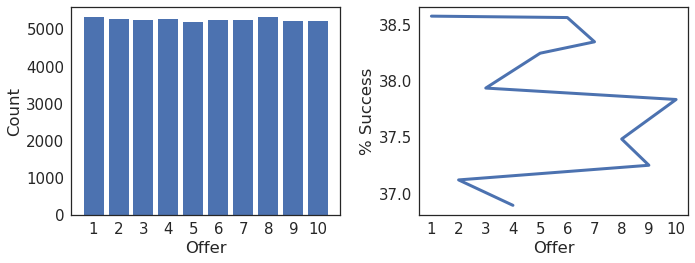

In [35]:
fig, axis = plt.subplots(figsize=(10, 4),nrows=1,ncols=2)
axis[0].bar(percent_success.index + 1, percent_success['count'])
axis[0].set_xticks(np.arange(0,10) + 1)
axis[0].set_xlabel('Offer')
axis[0].set_ylabel('Count')
axis[1].plot(percent_success.index + 1,percent_success['percentsuccess'],linewidth=3)
axis[1].set_xticks(np.arange(0,10) + 1)
axis[1].set_xlabel('Offer')
axis[1].set_ylabel('% Success')
plt.tight_layout()

### Transform variables

In [36]:
min_max = MinMaxScaler()
X_train[['difficulty', 'duration', 'reward', 'income']] = min_max.fit_transform(X_train[['difficulty', 'duration', 'reward', 'income']])
X_test[['difficulty', 'duration', 'reward', 'income']] = min_max.fit_transform(X_test[['difficulty', 'duration', 'reward', 'income']])

### Analyzing Customer data

In [37]:
def reverse_ohe(dataframe_row,is_ohe_column):
    """ Reverses categorical one hot encoding
    INPUT:
        dataframe_row: Pandas Series that stores a DataFrame row
        is_ohe_column: List that describes which DataFrame columns
                       correspond to the one hot encoding of a 
                       categorical variable
    OUTPUT:
        categorical_variable: String that stores the value of a
                              categorical variable"""
    column_idx = np.argwhere(dataframe_row[is_ohe_column])
    return str(dataframe_row.index.values[is_ohe_column][column_idx][0,0])
def init_customer_membershipstartyear(successful_offer,unsuccessful_offer):
    """
    Initializes a DataFrame that describes customer membership start year
    statistics associated with a particular offer
    INPUT:
        successful_offer: DataFrame that describes customers that an offer
                          was successful for
        unsuccessful_offer: DataFrame that describes customers that an offer
                            was not successful for
    OUTPUT:
        membershipstartyear: DataFrame that describes customer membership
                             start year statistics associated with a
                             particular offer
    """
    successful_membershipstartyear = init_membershipstartyear_histogram(successful_offer)
    unsuccessful_membershipstartyear = init_membershipstartyear_histogram(unsuccessful_offer,'No')
    customer_membershipstartyear = pd.concat([successful_membershipstartyear,unsuccessful_membershipstartyear],axis=0)
    return customer_membershipstartyear.reset_index(drop=True)
    
def init_membershipstartyear_histogram(dataframe,successful='Yes'):
    """ Initializes a DataFrame that describes customer membership start
    year statistics
    INPUT:
        dataframe: DataFrame that describes customer statistics
        successful: (Optional) String that describes whether an offer was
                    successful
    OUTPUT:
        histogram: DataFrame that describes customer membership start
                   year statistics"""
    histogram = dataframe['membershipstartyear'].value_counts()
    histogram *= 100 / histogram.sum()
    number_years = histogram.shape[0]
    histogram = pd.DataFrame(list(zip(histogram.index.values, histogram,np.repeat(successful, number_years))),columns=['membershipstartyear','percentage','successful'])
    histogram['membershipstartyear'] = histogram['membershipstartyear'].astype('int')
    return histogram.sort_values('membershipstartyear')

def print_customer_statistics(cur_offer_id,
                              customer_income,
                              customer_agerange):
    """Prints average customer income and age
    
    INPUT:
        cur_offer_id: String that refers to a specific offer
        customer_income: DataFrame that describes customer income statistics
                         associated with a specific offer
        customer_agerange: DataFrame that describes customer agerange
                           statistics associated with a particular offer
    OUTPUT:
        None
    """
    print("offerid: %s" % (cur_offer_id))
    print("Offer successful")
    print("\tAverage customer income: $%.1f" % compute_average_income(customer_income))
    print("\tAverage customer age: %.1f [years]" % compute_average_age(customer_agerange))
    print("Offer unsuccessful")
    print("\tAverage customer income: $%.1f" % compute_average_income(customer_income, 'No'))
    print("\tAverage customer age: %.1f [years]" % compute_average_age(customer_agerange, 'No'))
    
def compute_average_income(customer_income,
                           successful='Yes'):
    """ Computes the average customer income
    INPUT:
        customer_income: DataFrame that describes customer income statistics
                         associated with a specific offer
        successful: (Optional) String that describes whether an offer was
                    successful
    
    OUTPUT:
        average_income: Average customer income
    """
    select_data = customer_income['successful'] == successful
    cur_income = customer_income[select_data]['income']
    cur_probability = customer_income[select_data]['probability']
    cur_income_weighting = cur_probability / np.sum(cur_probability)
    return np.sum(cur_income * cur_income_weighting)

def compute_average_age(customer_agerange,
                        successful='Yes'):
    """ Computes the average customer age
    INPUT:
        customer_agerange: DataFrame that describes customer agerange
                           statistics associated with a particular offer
        successful: (Optional) String that describes whether an offer was
                    successful
    OUTPUT:
        average_age: Average customer age
    """
    select_data = customer_agerange['successful'] == successful
    cur_agerange = customer_agerange[select_data]['agerange']
    cur_percentage = customer_agerange[select_data]['percentage']
    pattern_obj = re.compile('^\[([0-9]+), ([0-9]+)\)$')
    min_age = [int(pattern_obj.match(elem).group(1)) for elem in cur_agerange]
    max_age = [int(pattern_obj.match(elem).group(2)) for elem in cur_agerange]
    avg_age = [np.mean(elem) for elem in zip(min_age, max_age)]
    return np.sum(avg_age * cur_percentage / 100)

def visualize_customer_statistics(cur_offer_id,
                                  customer_income,
                                  customer_gender,
                                  customer_agerange,
                                  membershipstartyear):
    """
    Visualizes customer statistics for a specific offer
    INPUT:
        customer_income: DataFrame that describes customer income statistics
                         associated with a specific offer
        customer_gender: DataFrame that describes customer gender statistics
                         associated with a particular offer
        customer_agerange: DataFrame that describes customer agerange
                           statistics associated with a particular offer
        membershipstartyear: DataFrame that describes customer membership
                             start year statistics associated with a
                             particular offer
    OUTPUT:
        None
    """
    income_bins = customer_income['income'].unique()
    xticks = np.array(np.arange(0, len(income_bins), 5))
    xticklabels = [income_bins[elem] / 1e3 for elem in xticks]
    xticklabels = ["%.1fK" % (elem) for elem in xticklabels]
    xticklabels
    min_income = np.floor(customer_income['income'].min() / 10e3) * 10e3
    max_income = np.ceil(customer_income['income'].max() / 10e3) * 10e3
    xticks = np.linspace(min_income, max_income, 5)
    xticks = np.array(np.arange(0, customer_income.shape[0], 5))
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 14))
    barobj = sns.barplot(x='income',y='probability',hue='successful',ax=ax[0],data=customer_income)
    barobj.set_xticks(xticks)
    barobj.set_xticklabels(xticklabels, rotation=90)
    barobj.set_xlim((0, len(income_bins)))
    barobj.set_xlabel('Customer Income')
    barobj.set_ylabel('P(Customer\nIncome)')
    barobj.set_title("offerid: %s " % (cur_offer_id))
    barobj = sns.barplot(x='gender',y='percentage',hue='successful',ax=ax[1],data=customer_gender)
    barobj.set_xlabel('Customer Gender')
    barobj.set_ylabel('% of Customers')
    barobj = sns.barplot(x='agerange',y='percentage',hue='successful',ax=ax[2],data=customer_agerange)
    barobj.set_xlabel('Customer Age Range')
    barobj.set_ylabel('% of Customers')
    barobj.set_xticklabels(barobj.get_xticklabels(), rotation=90)
    barobj = sns.barplot(x='membershipstartyear',y='percentage',hue='successful',ax=ax[3],data=membershipstartyear)
    plt.tight_layout()

def customer_offer(offer_number,percent_success,training_data,gender_integer_map):
    """ Make customer demographics visualization and computes
    summary statistics for a specific offer
    
    INPUT:
        offer_number: Integer that refers to a specific customer offer
        
        percent_success: DataFrame that describes the success percentage for
                         each offer
        training_data: DataFrame that stores customer demographic data
                       for a specific offer
                       
        gender_integer_map: Dictionary that describes the mapping of a
                            gender string to an integer
    OUTPUT:
        None"""
    cur_offer_id =percent_success.iloc[offer_number]['id']
    select_data = training_data['id'] == cur_offer_id
    cur_offer_data = training_data[select_data].copy()
    offer_successful = cur_offer_data['offersuccessful'].astype('bool')
    cur_offer_data = cur_offer_data.drop(columns=['id','offersuccessful'])
    successful_offer = cur_offer_data[offer_successful].copy()
    unsuccessful_offer = cur_offer_data[offer_successful == False].copy()
    pattern_obj = re.compile('^20[0-9]{2}$')
    is_start_year = [pattern_obj.match(str(elem)) != None for elem in successful_offer.columns.values]
    columns_to_drop = successful_offer.columns.values[is_start_year]
    h_transform = lambda elem: reverse_ohe(elem, is_start_year)
    successful_offer['membershipstartyear'] = successful_offer.apply(h_transform, axis=1)
    unsuccessful_offer['membershipstartyear'] = unsuccessful_offer.apply(h_transform, axis=1)
#     successful_offer = successful_offer.drop(columns=['id','offersuccessful'])
#     unsuccessful_offer = unsuccessful_offer.drop(columns=['id', 'offersuccessful'])
    pattern_obj = re.compile('^\[[0-9]+, [0-9]+\)$')
    is_age_range = [pattern_obj.match(elem) != None for elem in successful_offer.columns]
    columns_to_drop = successful_offer.columns.values[is_age_range]
    h_transform = lambda elem: reverse_ohe(elem, is_age_range)
    successful_offer['agerange'] = successful_offer.apply(h_transform, axis=1)
    unsuccessful_offer['agerange'] = unsuccessful_offer.apply(h_transform, axis=1)
#     successful_offer = successful_offer.drop(columns=['id', 'offersuccessful'])
#     unsuccessful_offer = unsuccessful_offer.drop(columns=['id','offersuccessful'])
    successful_offer.gender.replace({1:"Male",0:"Female"},inplace=True)
    unsuccessful_offer.gender.replace({1:"Male",0:"Female"},inplace=True)
    successful_offer = successful_offer.reset_index(drop=True)
    unsuccessful_offer = unsuccessful_offer.reset_index(drop=True)
    
    min_income = np.min([successful_offer['income'].min(),unsuccessful_offer['income'].min()])
    max_income = np.max([successful_offer['income'].max(),unsuccessful_offer['income'].max()])
    income_bins = np.linspace(min_income, max_income, 30)
    income_histogram = np.histogram(successful_offer['income'],income_bins,density=True)[0]
    column_names = ['income', 'probability', 'successful']
    successful_offer_income = pd.DataFrame(list(zip(income_bins,income_histogram,np.repeat('Yes', 30))),columns=column_names)
    income_histogram = np.histogram(unsuccessful_offer['income'],income_bins,density=True)[0]
    unsuccessful_offer_income = pd.DataFrame(list(zip(income_bins,income_histogram,np.repeat('No', 30))),columns=column_names)
    customer_income = pd.concat([successful_offer_income,unsuccessful_offer_income],axis=0)
    customer_income = customer_income.reset_index(drop=True)
    
    column_names = ['gender', 'percentage', 'successful']
    gender_histogram = successful_offer['gender'].value_counts()
    gender_histogram *= 100 / gender_histogram.sum()
    successful_offer_gender = pd.DataFrame(list(zip(gender_histogram.index.values,gender_histogram,np.repeat('Yes', 2))),columns=column_names)
    gender_histogram = unsuccessful_offer['gender'].value_counts()
    gender_histogram *= 100 / gender_histogram.sum()
    unsuccessful_offer_gender = pd.DataFrame(list(zip(gender_histogram.index.values,gender_histogram,np.repeat('No', 2))),columns=column_names)
    customer_gender = pd.concat([successful_offer_gender,unsuccessful_offer_gender],axis=0)
    customer_gender = customer_gender.reset_index(drop=True)
    column_names = ['agerange', 'percentage', 'successful']
    agerange_histogram = successful_offer['agerange'].value_counts()
    agerange_histogram *= 100 / agerange_histogram.sum()
    pattern_obj = re.compile('^\[([0-9]+), ([0-9]+)\)$')
    bin_start = [float(pattern_obj.match(elem).group(1)) for elem in agerange_histogram.index.values]
    bin_end = [float(pattern_obj.match(elem).group(2)) for elem in agerange_histogram.index.values]
    bin_center = [np.mean(elem) for elem in zip(bin_start, bin_end)]
    sorted_agerange_idx = np.argsort(bin_center)
    agerange_histogram = agerange_histogram.iloc[sorted_agerange_idx]
    successful_agerange = pd.DataFrame(list(zip(agerange_histogram.index.values,agerange_histogram,np.repeat('Yes', agerange_histogram.shape[0]))),columns=column_names)
    agerange_histogram = unsuccessful_offer['agerange'].value_counts()
    agerange_histogram *= 100 / agerange_histogram.sum()
    pattern_obj = re.compile('^\[([0-9]+), ([0-9]+)\)$')
    bin_start = [float(pattern_obj.match(elem).group(1)) for elem in agerange_histogram.index.values]
    bin_end = [float(pattern_obj.match(elem).group(2)) for elem in agerange_histogram.index.values]
    bin_center = [np.mean(elem) for elem in zip(bin_start, bin_end)]
    sorted_agerange_idx = np.argsort(bin_center)
    agerange_histogram = agerange_histogram.iloc[sorted_agerange_idx]
    unsuccessful_agerange = pd.DataFrame(list(zip(agerange_histogram.index.values,agerange_histogram,np.repeat('No', agerange_histogram.shape[0]))),columns=column_names)
    customer_agerange = pd.concat([successful_agerange,unsuccessful_agerange],axis=0)
    customer_agerange = customer_agerange.reset_index(drop=True)
    membershipstartyear = init_customer_membershipstartyear(successful_offer,unsuccessful_offer)
    print_customer_statistics(cur_offer_id,customer_income,customer_agerange)
    visualize_customer_statistics(cur_offer_id,customer_income,customer_gender,customer_agerange,membershipstartyear)

offerid: 0b1e1539f2cc45b7b9fa7c272da2e1d7
Offer successful
	Average customer income: $63944.0
	Average customer age: 54.8 [years]
Offer unsuccessful
	Average customer income: $63735.1
	Average customer age: 55.3 [years]


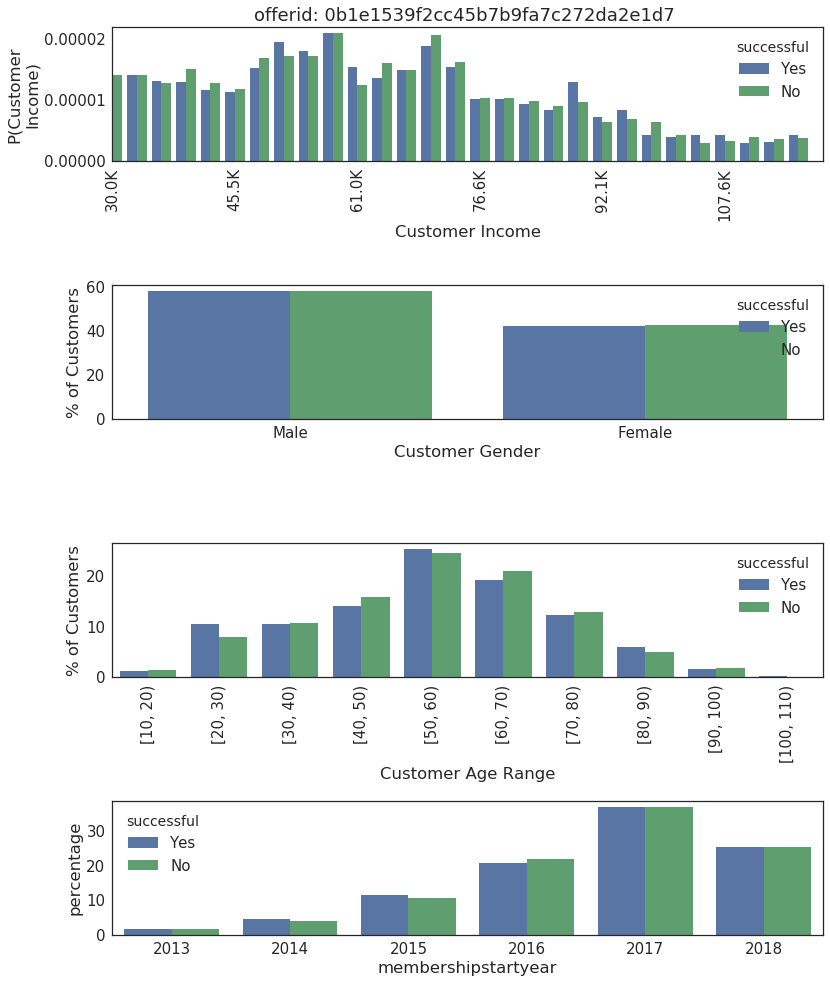

In [38]:
customer_offer(0, percent_success, train_data, gender_integer_map)

offerid: 5a8bc65990b245e5a138643cd4eb9837
Offer successful
	Average customer income: $63756.5
	Average customer age: 55.1 [years]
Offer unsuccessful
	Average customer income: $64181.0
	Average customer age: 55.6 [years]


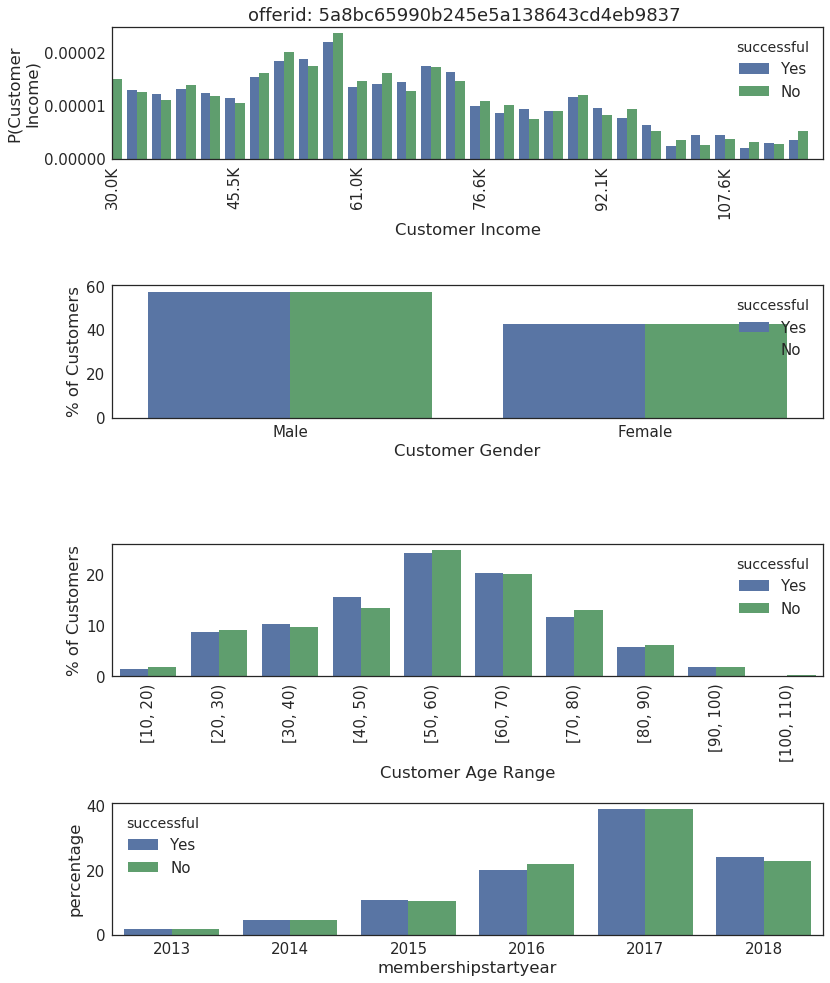

In [39]:
customer_offer(1, percent_success, train_data, gender_integer_map)

offerid: 9b98b8c7a33c4b65b9aebfe6a799e6d9
Offer successful
	Average customer income: $63556.8
	Average customer age: 55.2 [years]
Offer unsuccessful
	Average customer income: $63388.7
	Average customer age: 54.6 [years]


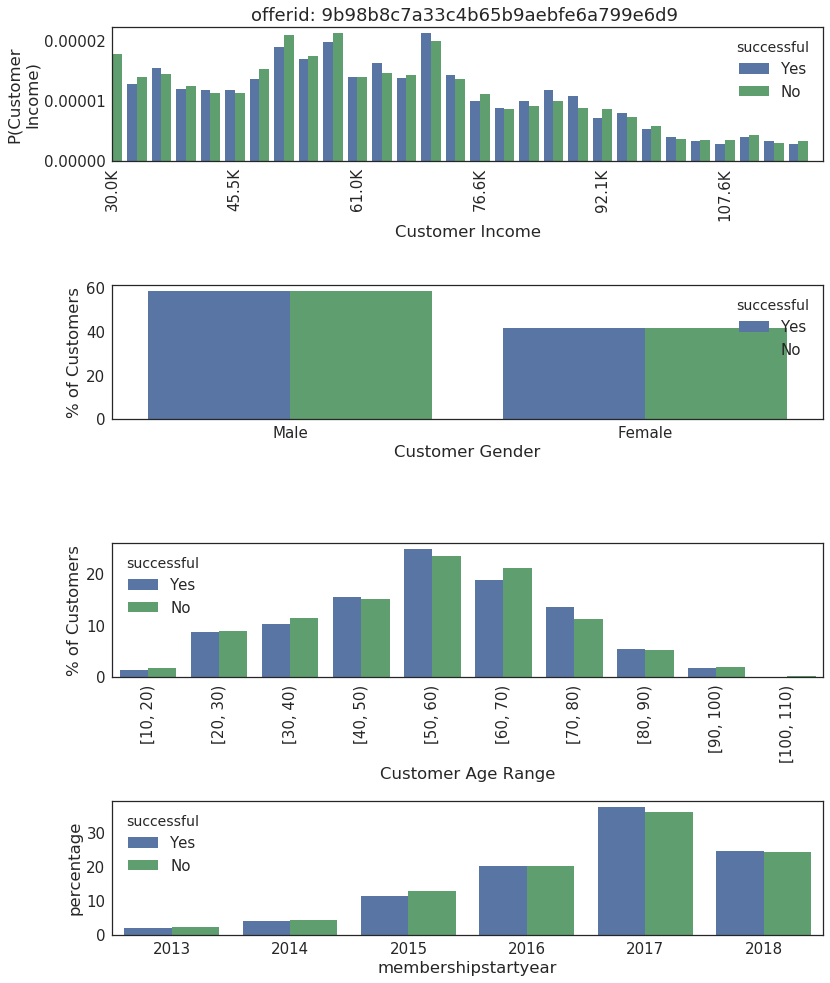

In [40]:
customer_offer(2, percent_success, train_data, gender_integer_map)

offerid: 4d5c57ea9a6940dd891ad53e9dbe8da0
Offer successful
	Average customer income: $64360.3
	Average customer age: 54.8 [years]
Offer unsuccessful
	Average customer income: $64048.5
	Average customer age: 54.9 [years]


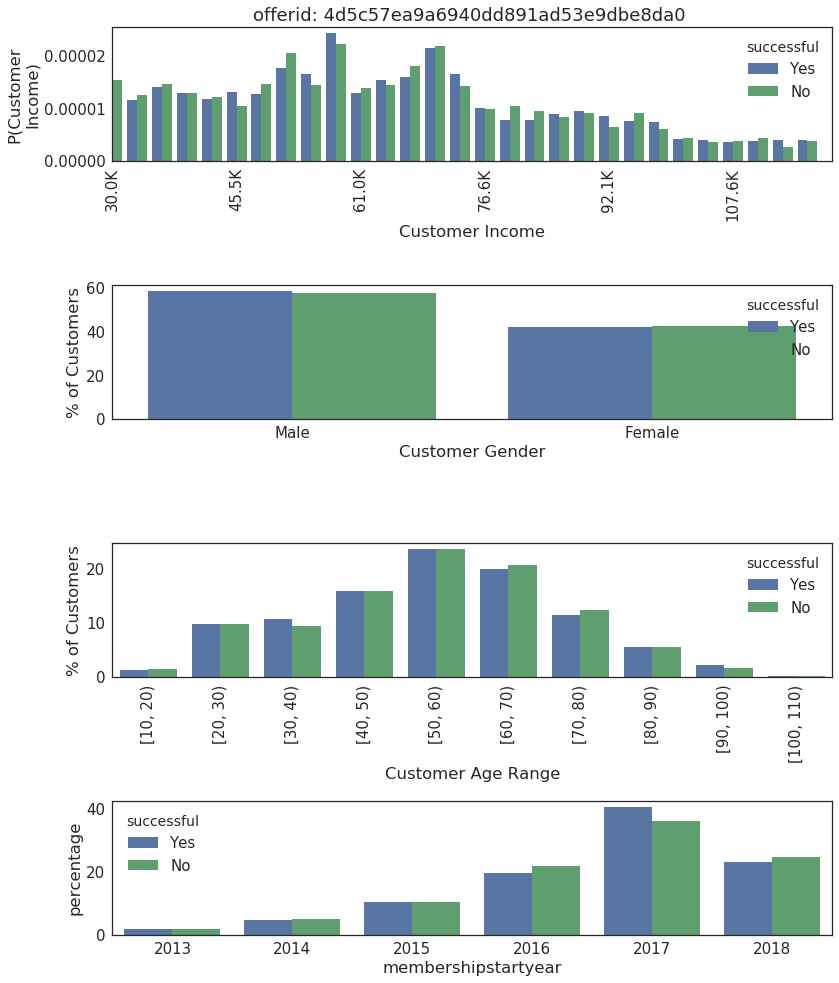

In [41]:
customer_offer(3, percent_success, train_data, gender_integer_map)

offerid: 2906b810c7d4411798c6938adc9daaa5
Offer successful
	Average customer income: $64729.3
	Average customer age: 54.5 [years]
Offer unsuccessful
	Average customer income: $63039.3
	Average customer age: 54.8 [years]


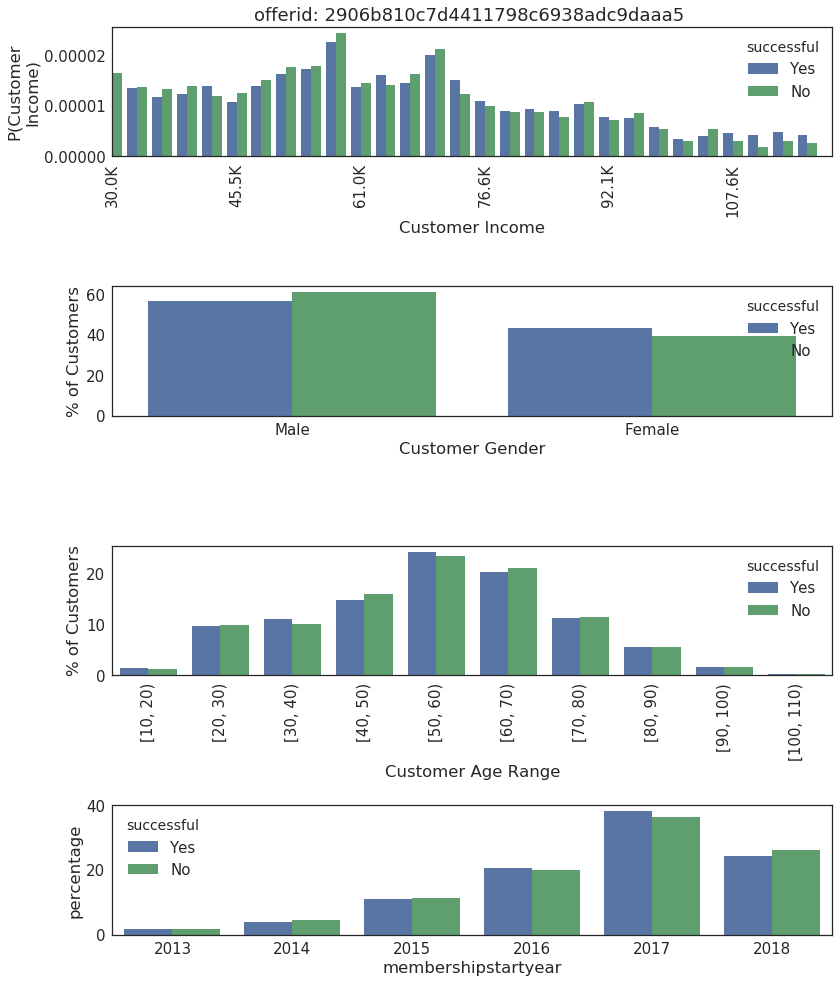

In [42]:
customer_offer(4, percent_success, train_data, gender_integer_map)

offerid: fafdcd668e3743c1bb461111dcafc2a4
Offer successful
	Average customer income: $64209.8
	Average customer age: 54.8 [years]
Offer unsuccessful
	Average customer income: $63624.8
	Average customer age: 55.2 [years]


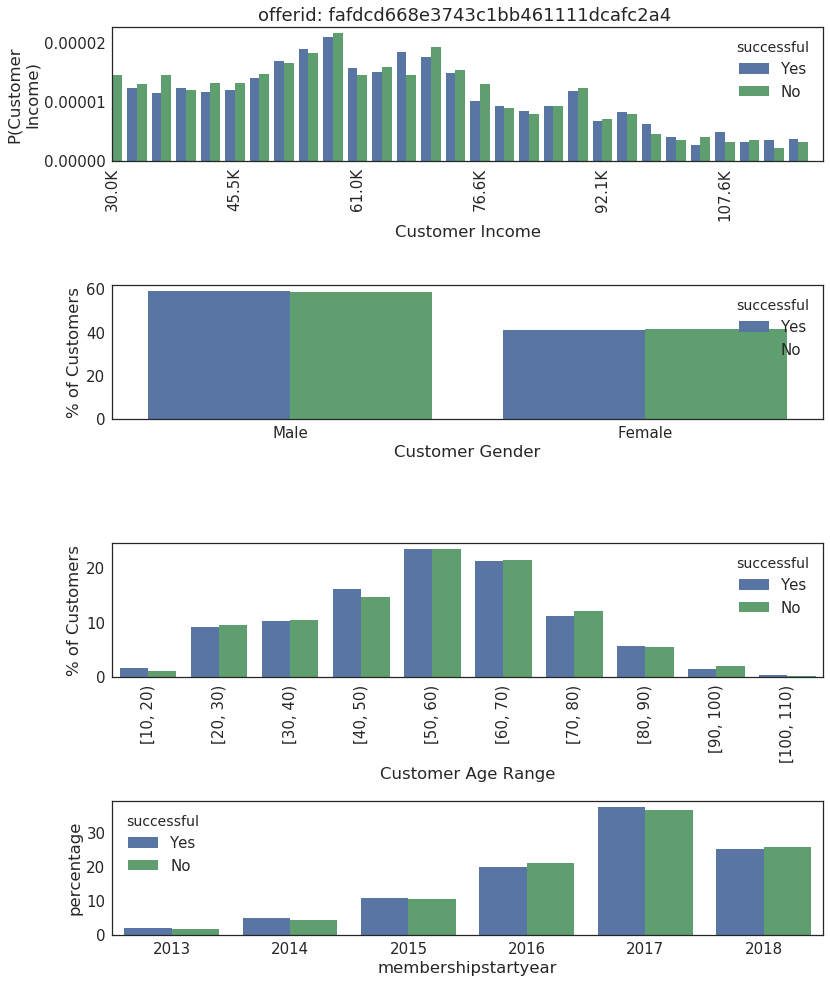

In [43]:
customer_offer(5, percent_success, train_data, gender_integer_map)

offerid: ae264e3637204a6fb9bb56bc8210ddfd
Offer successful
	Average customer income: $63857.6
	Average customer age: 54.7 [years]
Offer unsuccessful
	Average customer income: $64432.2
	Average customer age: 54.0 [years]


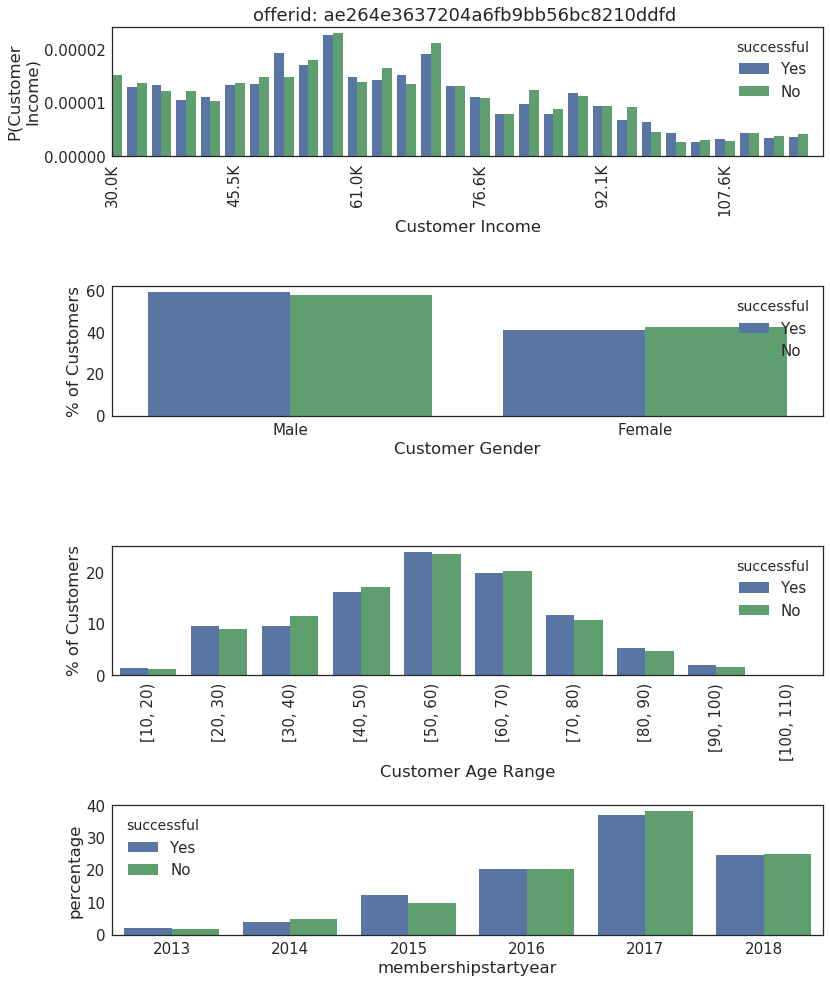

In [44]:
customer_offer(6, percent_success, train_data, gender_integer_map)

offerid: f19421c1d4aa40978ebb69ca19b0e20d
Offer successful
	Average customer income: $64192.6
	Average customer age: 55.1 [years]
Offer unsuccessful
	Average customer income: $63986.3
	Average customer age: 55.3 [years]


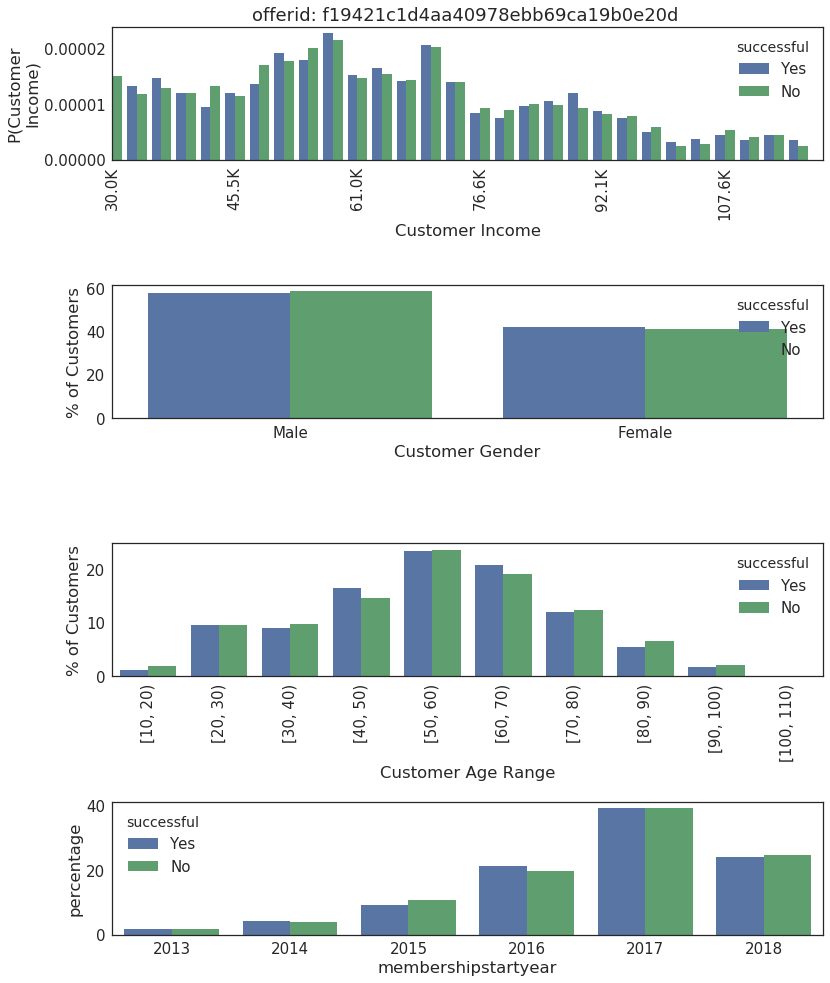

In [45]:
customer_offer(7, percent_success, train_data, gender_integer_map)

offerid: 2298d6c36e964ae4a3e7e9706d1fb8c2
Offer successful
	Average customer income: $64018.4
	Average customer age: 54.9 [years]
Offer unsuccessful
	Average customer income: $63132.5
	Average customer age: 54.0 [years]


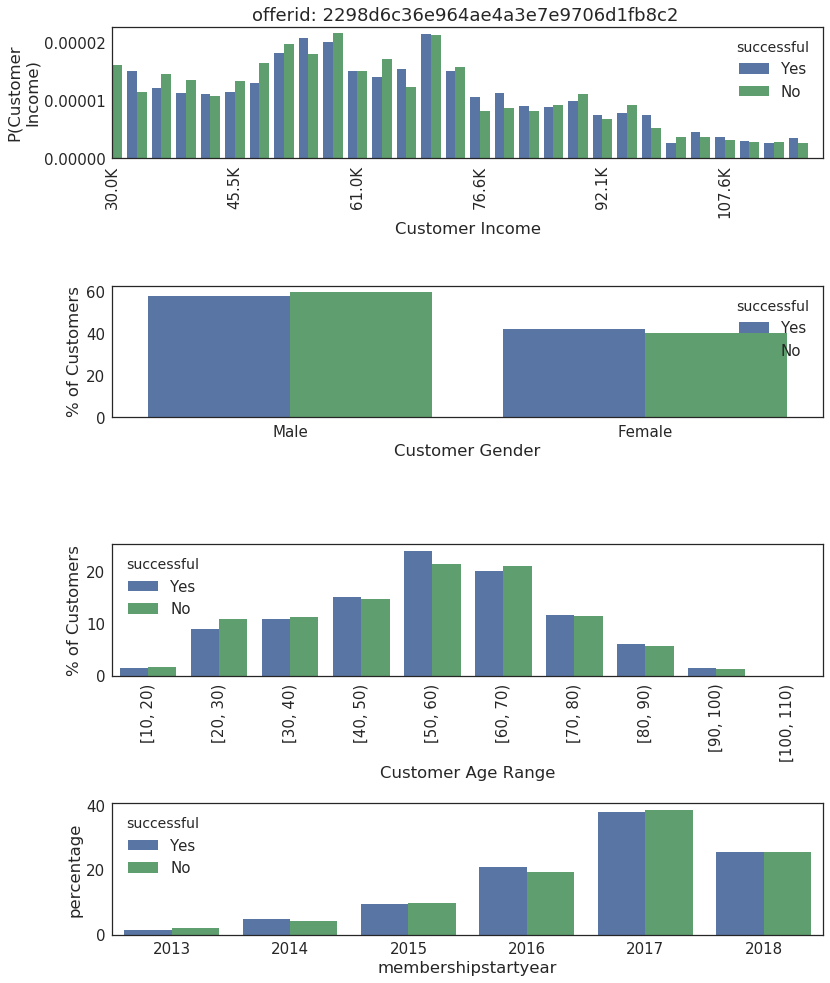

In [46]:
customer_offer(8, percent_success, train_data, gender_integer_map)

offerid: 3f207df678b143eea3cee63160fa8bed
Offer successful
	Average customer income: $63654.7
	Average customer age: 54.6 [years]
Offer unsuccessful
	Average customer income: $63732.0
	Average customer age: 55.5 [years]


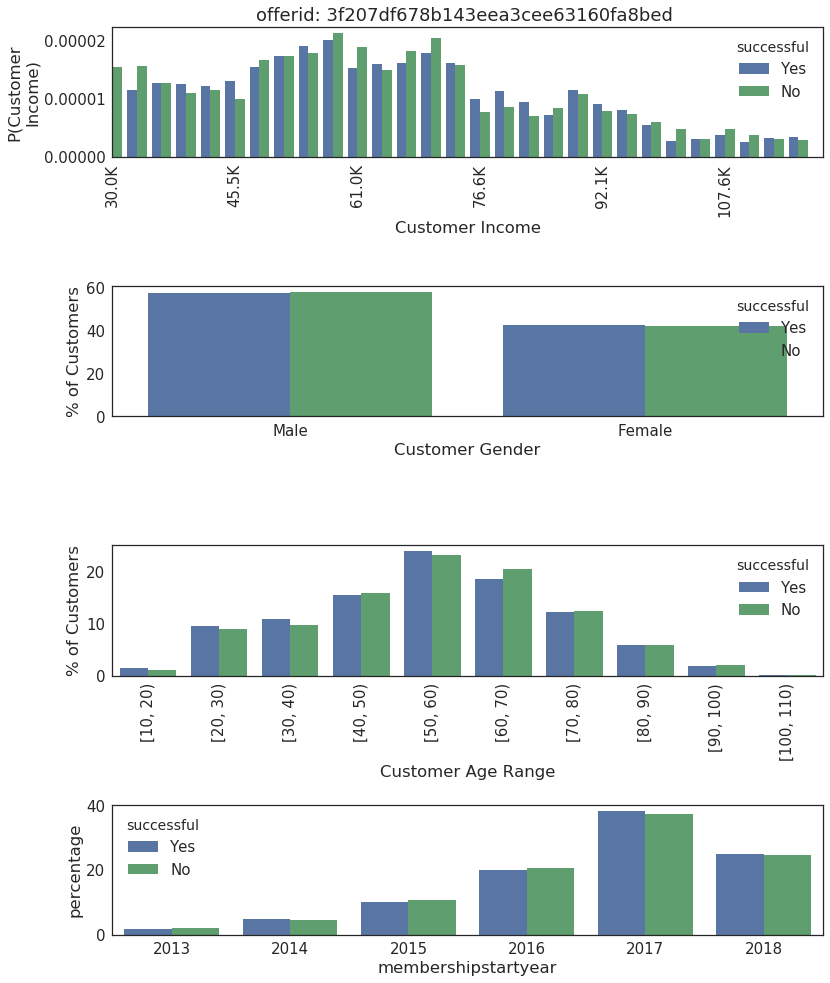

In [47]:
customer_offer(9, percent_success, train_data, gender_integer_map)

## Model Builiding And Prediction

### Using Logistic Regression:

In [48]:
lr = LogisticRegression(solver='liblinear')
random_grid = {'penalty': ['l1', 'l2'],'C': [1.0, 0.1, 0.01]}
lr_random = RandomizedSearchCV(estimator = lr,param_distributions = random_grid,n_iter = 6,cv = 3,verbose=2,n_jobs = 3)
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  45.6s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  46.0s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.1s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  47.6s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  1.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=6, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

#### Define model performance evaluation function

In [49]:
y_pred_lr = lr_random.predict(X_test)

In [50]:
accuracy_score(y_test,y_pred_lr)

0.72524205229854388

In [51]:
f1_score(y_test,y_pred_lr)

0.71795273125684778

### Using Random Forest:

In [52]:
rf = RandomForestClassifier()
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)
random_grid = {'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': max_depth,
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,n_iter = 100,cv = 3,verbose=2,n_jobs = 3)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  22.3s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  22.3s
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=  22.4s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4 
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=4 
[CV]  n_estimators=30, mi

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.3min


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=  13.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   6.2s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   6.2s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   6.2s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=  17.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_l

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  9.0min


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, total=  11.9s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.7s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   8.2s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   8.1s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   8.2s
[CV] n_estimators=30, min_samples_split=5, min_samples_leaf=1, 

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 18.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

#### Evalaute Random Forest Model Performance

In [53]:
y_pred_rf = rf_random.predict(X_test)

In [54]:
accuracy_score(y_test,y_pred_rf)

0.73599146146222461

In [55]:
f1_score(y_test,y_pred_rf)

0.72747304635240417

### Feature Importance

Text(0,0.5,'Feature')

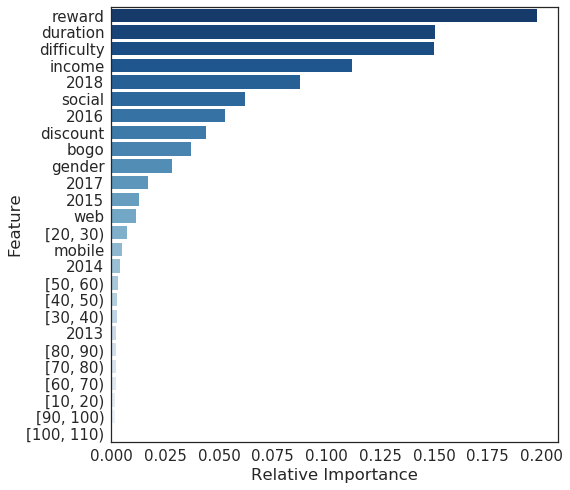

In [56]:
feature = rf_random.best_estimator_.feature_importances_
feature = feature / np.sum(feature)
imp_feature = pd.DataFrame(list(zip(column_names,feature)),columns=['feature', 'relativeimportance'])
imp_feature = imp_feature.sort_values('relativeimportance',ascending=False)
imp_feature = imp_feature.reset_index(drop=True)
ptt = sns.color_palette("Blues_r", imp_feature.shape[0])
plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=imp_feature,
            palette=ptt)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')

#### Top 8 features

In [57]:
imp_feature.head(n=8)

,feature,relativeimportance
0,reward,0.197774
1,duration,0.150634
2,difficulty,0.150084
3,income,0.111847
4,2018,0.087825
5,social,0.061954
6,2016,0.052617
7,discount,0.043764


### Construct Gradient Boosting Model

In [58]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

#### Evaluate Gradient Boosting Model Performance

In [59]:
y_pred_gb = gb.predict(X_test)

In [60]:
accuracy_score(y_test,y_pred_gb)

0.73652512007318749

In [61]:
f1_score(y_test,y_pred_gb)

0.72536554354736194

### Construct Adaboost Model

In [62]:
ab = AdaBoostClassifier()
ab.fit(X_test,y_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

#### Evaluate AdaBoost Model Performance

In [63]:
y_pred_ab = ab.predict(X_test)

In [64]:
accuracy_score(y_test,y_pred_ab)

0.73073111229701915

In [65]:
f1_score(y_test,y_pred_ab)

0.72414870353014693

## Conclusion
Here we build a model that predicts whether a customer will repond to an offer or not. Here first we combine our dataset then we do some analysis on the data and next we build a model and evaluate the accuracy and f1 score as the performance metrics. Here we saw that Gradient Boosting gave a high accuracy and F1 score compared to other models.